In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
from bs4 import BeautifulSoup
import re
from gensim.models.coherencemodel  import CoherenceModel
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data = pd.read_csv('Reddit_Data.csv' , delimiter=',' , encoding='latin-1' )
data.head(20)

FileNotFoundError: [Errno 2] No such file or directory: 'Reddit_Data.csv'

In [ ]:
# create a doc list that contains all the documents
doc_list = []
for i in range(len(data)):
    doc_list.append(data['clean_comment'][i])

In [ ]:
# pre-processing
data.drop(['category'] , axis=1, inplace=True)

## Preprocessing and cleaning the data :

In [ ]:
# drop rows with empty comments
data = data[data['clean_comment'].apply(lambda x: isinstance(x, str))]
# Remove URLs
data['clean_comment'] = data['clean_comment'].apply(lambda x: re.sub(r'http\S+', '', x))
# Remove digits
data['clean_comment'] = data['clean_comment'].apply(lambda x: re.sub(r'\d+', '', x))
# Remove HTML tags
data['clean_comment'] = data['clean_comment'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
# Remove punctuation
data['clean_comment'] = data['clean_comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

data = data[data['clean_comment'].apply(lambda x: isinstance(x, str))]
doc_list = []
doc_list = data['clean_comment']

 # Tokenization
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
data['clean_comment'] = data['clean_comment'].apply(lambda x: tokenizer.tokenize(x) if isinstance(x, str) else [])

# Remove punctuation and stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['...', '…'])
data['clean_comment'] = data['clean_comment'].apply(
    lambda tokens: [token.lower() for token in tokens if token not in stop_words and token not in string.punctuation]
)

# remove lines that contain less than 3 words or contain non-alphabetic characters
data = data[data['clean_comment'].apply(lambda x: len(x) >= 3 and all([type(token) == str and token.isalpha() for token in x]))]

# drop duplicates and empty comments
data.drop_duplicates(subset=['clean_comment'], inplace=True)
data['clean_comment'] = data['clean_comment'].apply(tuple)
data.drop_duplicates(subset=['clean_comment'], inplace=True)

data.dropna(subset=['clean_comment'], inplace=True)
data.head()
# print(len(data))

C:\Users\X280\AppData\Local\Temp\ipykernel_2408\3890306228.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  data['clean_comment'] = data['clean_comment'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())


,clean_comment
0,"(family, mormon, never, tried, explain, still,..."
1,"(buddhism, much, lot, compatible, christianity..."
2,"(seriously, say, thing, first, get, complex, e..."
3,"(learned, want, teach, different, focus, goal,..."
4,"(benefit, may, want, read, living, buddha, liv..."


In [ ]:
# print the number of documents in doc_list
print('Number of documents: ', len(doc_list))
# store only 1000 documents in doc_list
doc_list = doc_list[:5000]


Number of documents:  10000


In [ ]:
# we add some words to the stop word list
texts, article, skl_texts = [], [], []
for w in doc_list:
    w= nlp(str(w))
    for i in w :
        # if it's not a stop word or punctuation mark, add it to our article!
        if i.text != '\n' and not i.is_stop and not i.is_punct and not i.like_num:
            # we add the lematized version of the word
            article.append(i.lemma_)
        # if it's a new line, it means we're onto our next document
        if i.text == '\n':
            skl_texts.append(' '.join(article))
            texts.append(article)
            article = []

# LdaModel : Latent Dirichlet allocation

In [ ]:
from gensim import corpora
from gensim.models import LdaModel

# Create a dictionary from cleaned tokens
dictionary = corpora.Dictionary(data['clean_comment'])

# Create a corpus from cleaned tokens
corpus = [dictionary.doc2bow(tokens) for tokens in data['clean_comment']]

# Apply LDA model to the corpus
num_topics =20
start_time = time.time()
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
lda_training_time = time.time() - start_time
print('LDA training time: ', lda_training_time, 'seconds.')


LDA training time:  18.38769793510437 seconds.


In [ ]:
# print the keywords in the 5 topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.034*"kya" + 0.022*"read" + 0.020*"nahi" + 0.013*"kuch" + 0.013*"war" + 0.012*"military" + 0.012*"unemployment" + 0.010*"surprised" + 0.010*"overall" + 0.010*"literally"
Topic: 1 
Words: 0.049*"free" + 0.033*"team" + 0.032*"space" + 0.019*"dude" + 0.019*"source" + 0.019*"chutiya" + 0.018*"list" + 0.009*"sometimes" + 0.009*"kids" + 0.009*"curious"
Topic: 2 
Words: 0.009*"rahul" + 0.009*"gandhi" + 0.008*"one" + 0.008*"satellite" + 0.008*"use" + 0.007*"post" + 0.007*"also" + 0.007*"even" + 0.006*"think" + 0.006*"would"
Topic: 3 
Words: 0.032*"minister" + 0.022*"prime" + 0.020*"modi" + 0.016*"kashmir" + 0.011*"year" + 0.010*"women" + 0.009*"narendra" + 0.008*"missile" + 0.007*"super" + 0.007*"singh"
Topic: 4 
Words: 0.017*"modiji" + 0.017*"forces" + 0.014*"sabha" + 0.013*"funny" + 0.012*"jai" + 0.012*"jpg" + 0.010*"make" + 0.010*"freedom" + 0.009*"lok" + 0.008*"defence"
Topic: 5 
Words: 0.054*"news" + 0.028*"one" + 0.027*"thing" + 0.019*"video" + 0.018*"lol" + 0.017*"love

In [ ]:
# Compute Perplexity
Perplexity_lda = lda_model.log_perplexity(corpus)
print('\nPerplexity LDA: ',Perplexity_lda )  # a measure of how good the model is. lower the better.

# Compute Coherence Score which is the average /median of the pairwise word-similarity scores of the words in the topic.

coherence_model_lda = CoherenceModel(model=lda_model, texts=data['clean_comment'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDA: ', coherence_lda)


Perplexity LDA:  -12.7074054095413

Coherence Score LDA:  0.4148326022855163


# LSIModel : Latent semantic indexing

In [ ]:
# Apply LSA model to the corpus
from gensim.models import LsiModel

start_time = time.time()
lsi_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
lsi_training_time = time.time() - start_time
print('LSA training time: ', lsi_training_time, 'seconds.')


for idx, topic in lsi_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


LSA training time:  7.412955045700073 seconds.
Topic: 0 
Words: 0.348*"people" + 0.279*"india" + 0.261*"like" + 0.235*"bjp" + 0.204*"good" + 0.200*"modi" + 0.174*"one" + 0.169*"even" + 0.163*"would" + 0.120*"think"
Topic: 1 
Words: -0.542*"team" + -0.540*"free" + -0.523*"encyclopedia" + -0.318*"reached" + -0.126*"sports" + -0.083*"greece" + 0.066*"good" + -0.048*"list" + -0.043*"post" + -0.029*"best"
Topic: 2 
Words: 0.876*"good" + 0.373*"movie" + 0.178*"bollywood" + -0.087*"india" + -0.086*"people" + -0.072*"bjp" + -0.051*"modi" + 0.047*"results" + -0.045*"like" + 0.039*"team"
Topic: 3 
Words: -0.635*"best" + -0.614*"overall" + -0.334*"submitter" + -0.315*"post" + 0.034*"people" + 0.033*"free" + 0.030*"encyclopedia" + 0.026*"team" + 0.022*"reached" + 0.020*"bjp"
Topic: 4 
Words: 0.986*"ml" + 0.096*"ltr" + 0.056*"whisky" + 0.048*"scotch" + 0.043*"years" + 0.033*"black" + 0.032*"lable" + 0.024*"dog" + 0.024*"blue" + 0.024*"tetra"
Topic: 5 
Words: -0.894*"movie" + 0.385*"good" + -0.146*"

In [ ]:
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data['clean_comment'], dictionary=dictionary, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score LSI: ', coherence_lsi)


Coherence Score LSI:  0.4519185870991912


# HDP : Hierarchical Dirichlet process


In [ ]:
# Apply HDP model to the corpus
from gensim.models import HdpModel

start_time = time.time()
hdp_model = HdpModel(corpus=corpus, id2word=dictionary   )
hdp_training_time = time.time() - start_time
print('HDP training time: ', hdp_training_time, 'seconds.')
# print the keywords in the 5 topics
for idx, topic in hdp_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

HDP training time:  94.8316376209259 seconds.


In [ ]:
coherence_model_hdp = CoherenceModel(model=hdp_model, texts=data['clean_comment'], dictionary=dictionary, coherence='c_v')
coherence_hdp = coherence_model_hdp.get_coherence()
print('\nCoherence Score of hdp model : ', coherence_hdp)


Coherence Score of hdp model :  0.4860435266418752


# Dynamic Topic Modelling (DTM)

In [ ]:

# # # Apply DTM model to the corpus
# from gensim.models.wrappers import DtmModel

# dtm_path = './dtm/dtm/main.c'
# time_seq = [1] * len(corpus)
# model = DtmModel(dtm_path, corpus, time_seq, num_topics=2,
#                  id2word=dictionary, initialize_lda=True)


<h1> Topic Modelling with scikit-learn </h1>

Let us now use NMF and LDA which is available in sklearn to see how these topics work.

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [ ]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
# documents

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d: \n" % (topic_idx))
        for i in topic.argsort()[:-no_top_words - 1:-1] :
              print (" ".join([feature_names[i] ,]))

In [ ]:
no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(skl_texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(skl_texts)
tf_feature_names = tf_vectorizer.get_feature_names_out()

no_topics = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation( max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

Topic 0: 

modi
bjp
vote
people
like
india
know
time
congress
want
Topic 1: 

search
flight
malaysia
mh
satellite
debris
area
plane
ship
weather
Topic 2: 

aap
bjp
seat
delhi
win
kejriwal
bedi
poll
congress
exit
Topic 3: 

text
table
suit
upa
compare
nda
economic
freebie
growth
parliament
Topic 4: 

aircraft
information
search
area
international
likely
datum
analysis
ocean
piece
Topic 5: 

goal
game
match
yeah
lol
like
look
play
minute
fuck
Topic 6: 

muslim
hindu
india
religion
people
muslims
idea
hindus
country
faith
Topic 7: 

aap
party
corrupt
congress
don
bjp
attitude
corruption
people
non
Topic 8: 

travel
fuel
plane
fast
increase
lose
result
international
analysis
ocean
Topic 9: 

india
government
section
post
like
law
people
need
court
freedom
Topic 0: 

like
modi
aap
people
bjp
think
india
don
party
government
Topic 1: 

ego
jpg
armor
suit
gear
drug
punjab
look
like
raid
Topic 2: 

bjp
modi
india
people
like
muslim
good
aap
hindu
party
Topic 3: 

bjp
modi
india
aap
people
vote

<h2> pyLDAvis </h2>

In [ ]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.160957 -0.059997       1        1  11.571763
19     0.138731 -0.037797       2        1  11.103354
6      0.160562  0.009851       3        1  10.431566
13     0.143720  0.092827       4        1   8.325683
11     0.099380 -0.019315       5        1   8.056890
2      0.110992  0.000355       6        1   6.928598
18     0.116036  0.018879       7        1   6.164312
8      0.068569 -0.101701       8        1   4.135202
9      0.023914  0.017538       9        1   3.772649
16    -0.041115  0.060960      10        1   3.688003
3     -0.013917  0.054846      11        1   3.471235
5     -0.092688 -0.080657      12        1   3.018805
10    -0.107877  0.256762      13        1   2.954062
12    -0.036662 -0.086822      14        1   2.651781
7     -0.051348  0.080328      15        1   2.533991
4     -0.082212 -0.010525      16        1   2.459251
15    -0.153875 -0.039051      17        1   2.302274
14    -0.087905 -0.011403      18        1   2.286720
1     -0.227055 -0.042279      19        1   2.084373
0     -0.128207 -0.102798      20        1   2.059488, topic_info=          Term         Freq        Total Category  logprob  loglift
1346       bjp  5176.000000  5176.000000  Default  30.0000  30.0000
2090       hai  1811.000000  1811.000000  Default  29.0000  29.0000
1343  congress  2805.000000  2805.000000  Default  28.0000  28.0000
295       good  2695.000000  2695.000000  Default  27.0000  27.0000
1731      news  1372.000000  1372.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
296      great   106.793657   738.976203  Topic20  -4.7685   1.9483
1034  american    65.207998   115.152319  Topic20  -5.2619   3.3140
122       want    86.695505  1487.876641  Topic20  -4.9770   1.0400
147     people    91.070784  5498.336286  Topic20  -4.9278  -0.2179
1601     wants    71.584392   388.439956  Topic20  -5.1686   2.1915

[1331 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4394     16  0.966928    aadmi
8750     15  0.976798      aaj
3784      1  0.005767      aap
3784      2  0.017301      aap
3784      3  0.067281      aap
...     ...       ...      ...
5877      8  0.020897  youtube
5877     10  0.004179  youtube
5877     16  0.008359  youtube
5877     17  0.932011  youtube
7955      1  0.980013      yrs

[5411 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 20, 7, 14, 12, 3, 19, 9, 10, 17, 4, 6, 11, 13, 8, 5, 16, 15, 2, 1])

<h2> Evaluation </h2>

In [ ]:
def evaluate_bar_graph(coherences, indices , label):

    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel(label)

<h1> Topic Coherence </h1>


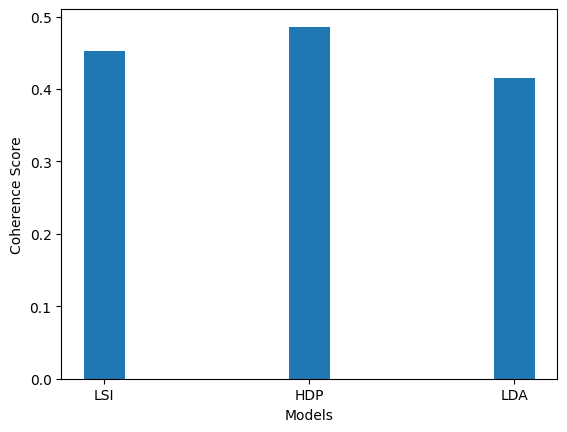

In [ ]:
evaluate_bar_graph([coherence_lsi, coherence_hdp, coherence_lda],
                   ['LSI', 'HDP', 'LDA'] , 'Coherence Score')

<h2> Training time :</h2>

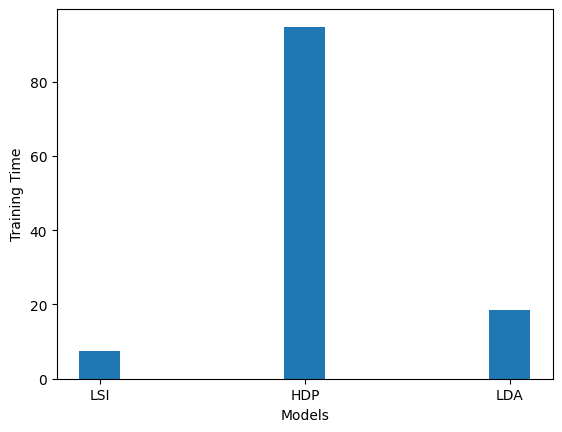

In [ ]:
evaluate_bar_graph([lsi_training_time, hdp_training_time, lda_training_time],
                   ['LSI', 'HDP', 'LDA'] , 'Training Time')

<h2> Topic Overlap: </h2>



In [ ]:
# Show top words per topic
for model, name in zip([lsi_model, hdp_model, lda_model], ['LSI', 'HDP', 'LDA']):
    print(f"Top words for {name}:\n{model.show_topics()}\n")

Top words for LSI:
[(0, '0.348*"people" + 0.279*"india" + 0.261*"like" + 0.235*"bjp" + 0.204*"good" + 0.200*"modi" + 0.174*"one" + 0.169*"even" + 0.163*"would" + 0.120*"think"'), (1, '-0.542*"team" + -0.540*"free" + -0.523*"encyclopedia" + -0.318*"reached" + -0.126*"sports" + -0.083*"greece" + 0.066*"good" + -0.048*"list" + -0.043*"post" + -0.029*"best"'), (2, '0.876*"good" + 0.373*"movie" + 0.178*"bollywood" + -0.087*"india" + -0.086*"people" + -0.072*"bjp" + -0.051*"modi" + 0.047*"results" + -0.045*"like" + 0.039*"team"'), (3, '-0.635*"best" + -0.614*"overall" + -0.334*"submitter" + -0.315*"post" + 0.034*"people" + 0.033*"free" + 0.030*"encyclopedia" + 0.026*"team" + 0.022*"reached" + 0.020*"bjp"'), (4, '0.986*"ml" + 0.096*"ltr" + 0.056*"whisky" + 0.048*"scotch" + 0.043*"years" + 0.033*"black" + 0.032*"lable" + 0.024*"dog" + 0.024*"blue" + 0.024*"tetra"'), (5, '-0.894*"movie" + 0.385*"good" + -0.146*"bollywood" + -0.113*"bjp" + 0.058*"well" + -0.051*"modi" + -0.039*"congress" + -0.02

<h2> Word cloud </h2>

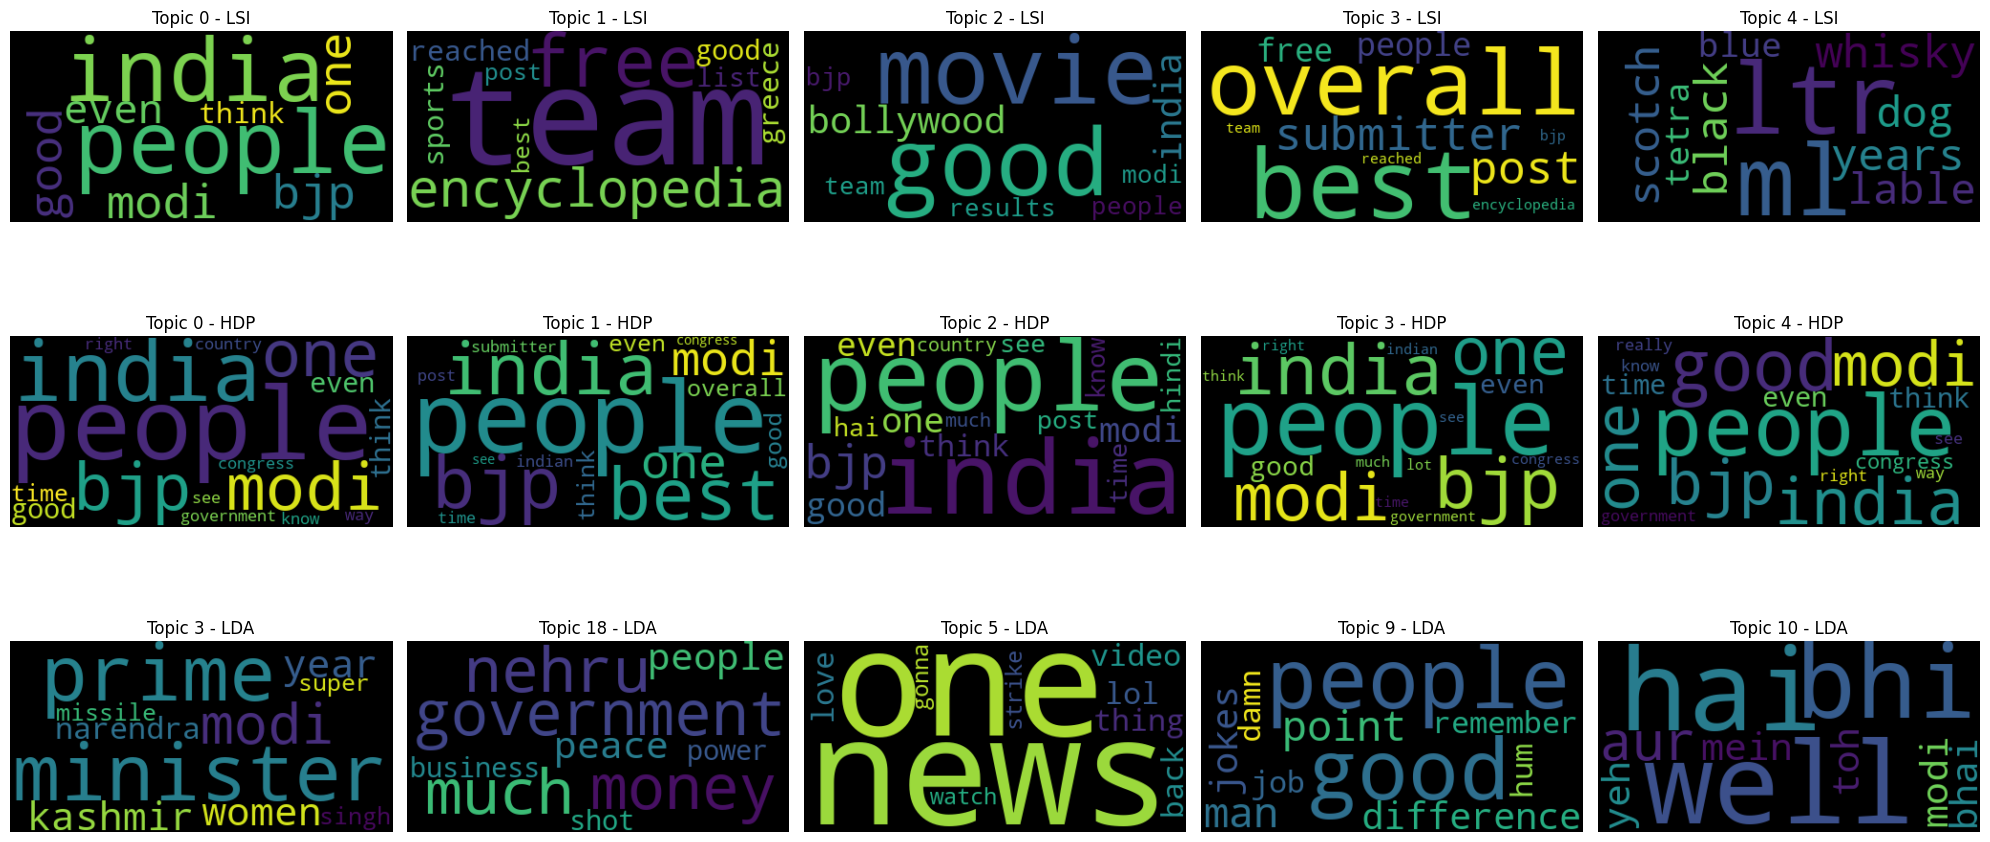

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

from wordcloud import WordCloud  # Import WordCloud class

# ignore warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Number of topics to display
num_topics_to_display = 5

# Create subplots
fig, axs = plt.subplots(3, num_topics_to_display, figsize=(20, 10))

gs = gridspec.GridSpec(3, num_topics_to_display, width_ratios=[1] * num_topics_to_display)

# Visualize word clouds for top words in each topic
for i, (model, name) in enumerate(zip([lsi_model, hdp_model, lda_model], ['LSI', 'HDP', 'LDA'])):
    for j, (topic_id, words) in enumerate(model.show_topics(num_topics=num_topics_to_display)):
        wordcloud = WordCloud().generate(words)
        axs[i, j].imshow(wordcloud, interpolation='bilinear')
        axs[i, j].set_title(f'Topic {topic_id} - {name}')
        axs[i, j].axis("off")

# Adjust layout

plt.tight_layout()
plt.show()
